In [31]:
import logging
import math
import numpy as np


import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch import nn
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [32]:
# Generate the dataset
num_samples = 3000
x = torch.linspace(-15, 15, num_samples).unsqueeze(1)
y = np.power(x, 2)

# Split the dataset into training and validation sets
train_size = int(0.7 * num_samples)
train_x, val_x = x[:train_size], x[train_size:]
train_y, val_y = y[:train_size], y[train_size:]

# Define the neural network model
class QuadraticNet(nn.Module):
    def __init__(self):
        super(QuadraticNet, self).__init__()
        self.fc1 = nn.Linear(1, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
class ICNN(nn.Module):
    def __init__(self, layer_sizes, activation=F.relu_):
        super().__init__()
        self.W = nn.ParameterList([nn.Parameter(torch.Tensor(l, layer_sizes[0])) 
                                   for l in layer_sizes[1:]])
        self.U = nn.ParameterList([nn.Parameter(torch.Tensor(layer_sizes[i+1], layer_sizes[i]))
                                   for i in range(1,len(layer_sizes)-1)])
        self.bias = nn.ParameterList([nn.Parameter(torch.Tensor(l)) for l in layer_sizes[1:]])
        self.act = activation
        self.reset_parameters()
        print(f"Initialized ICNN with {self.act} activation")

    def reset_parameters(self):
        # copying from PyTorch Linear
        for W in self.W:
            nn.init.kaiming_uniform_(W, a=5**0.5)
        for U in self.U:
            nn.init.kaiming_uniform_(U, a=5**0.5)
        for i,b in enumerate(self.bias):
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W[i])
            bound = 1 / (fan_in**0.5)
            nn.init.uniform_(b, -bound, bound)

    def forward(self, x):
        z = F.linear(x, self.W[0], self.bias[0])
        z = self.act(z)

        for W,b,U in zip(self.W[1:-1], self.bias[1:-1], self.U[:-1]):
            z = F.linear(x, W, b) + F.linear(z, F.softplus(U)) / U.shape[0]
            z = self.act(z)

        return F.linear(x, self.W[-1], self.bias[-1]) + F.linear(z, F.softplus(self.U[-1])) / self.U[-1].shape[0]

In [33]:
def plot_predictions(model, x_test, y_test):
    """
    Plots the input-output relationship for the quadratic function,
    along with the model's predictions.
    
    Args:
        model (nn.Module): Trained PyTorch model.
        x_test (torch.Tensor): Test input data.
        y_test (torch.Tensor): Test target data.
    """
    model.eval()
    # Make predictions using the trained model
    with torch.no_grad():
        y_pred = model(x_test)
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot the true quadratic function
    ax.plot(x_test.squeeze(), y_test.squeeze(), label='True function')
    
    # Plot the model's predictions
    ax.plot(x_test.squeeze(), y_pred.squeeze(), label='Model predictions')
    
    # Set labels and title
    ax.set_xlabel('Input (x)')
    ax.set_ylabel('Output (y)')
    ax.set_title('True Function and Model Predictions')
    ax.legend()
    
    plt.show()

Initialized ICNN with <built-in method relu_ of type object at 0x130d97810> activation
Epoch [100/10000], Train Loss: 4562.3871, Val Loss: 12353.2158
Epoch [200/10000], Train Loss: 2826.8544, Val Loss: 12505.3301
Epoch [300/10000], Train Loss: 1418.6922, Val Loss: 12412.6377
Epoch [400/10000], Train Loss: 746.3757, Val Loss: 12163.3906
Epoch [500/10000], Train Loss: 609.5678, Val Loss: 11622.5459
Epoch [600/10000], Train Loss: 578.7425, Val Loss: 10895.8643
Epoch [700/10000], Train Loss: 555.3106, Val Loss: 10154.9912
Epoch [800/10000], Train Loss: 533.5881, Val Loss: 9467.6045
Epoch [900/10000], Train Loss: 513.2166, Val Loss: 8867.4072
Epoch [1000/10000], Train Loss: 493.9935, Val Loss: 8371.7764
Epoch [1100/10000], Train Loss: 475.7131, Val Loss: 7979.2437
Epoch [1200/10000], Train Loss: 458.1999, Val Loss: 7671.5195
Epoch [1300/10000], Train Loss: 441.3350, Val Loss: 7424.3467
Epoch [1400/10000], Train Loss: 425.0396, Val Loss: 7216.2056
Epoch [1500/10000], Train Loss: 409.2575, Va

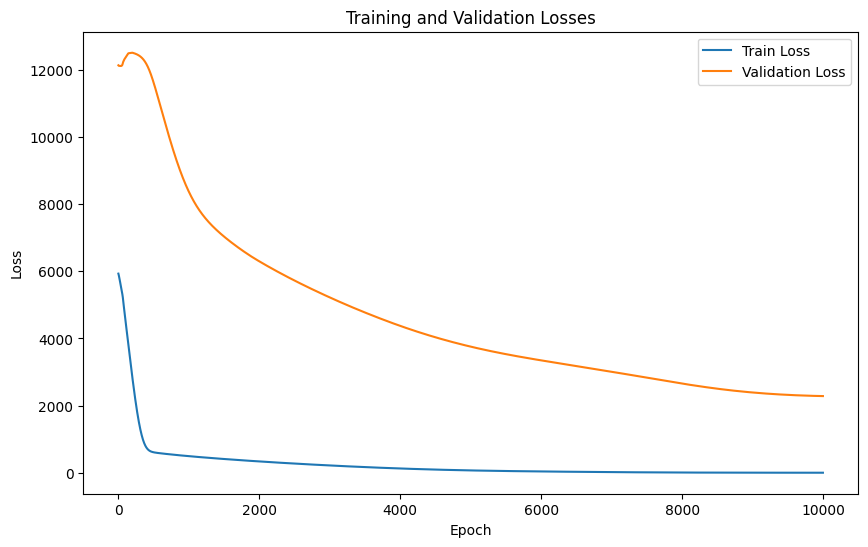

In [34]:
# Create the model, optimizer, and loss function
model = ICNN([1, 6, 6, 6, 1]) #QuadraticNet()
optimizer = optim.Adam(model.parameters(), lr=0.00005)
criterion = nn.MSELoss()

# Training loop
num_epochs = 10000
batch_size = 32
num_batches = train_size // batch_size
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    for batch in range(num_batches):
        start = batch * batch_size
        end = (batch + 1) * batch_size
        batch_x = train_x[start:end]
        batch_y = train_y[start:end]

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    train_losses.append(train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(val_x)
        val_loss = criterion(val_outputs, val_y)
    val_losses.append(val_loss.item())

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')

# Plot the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

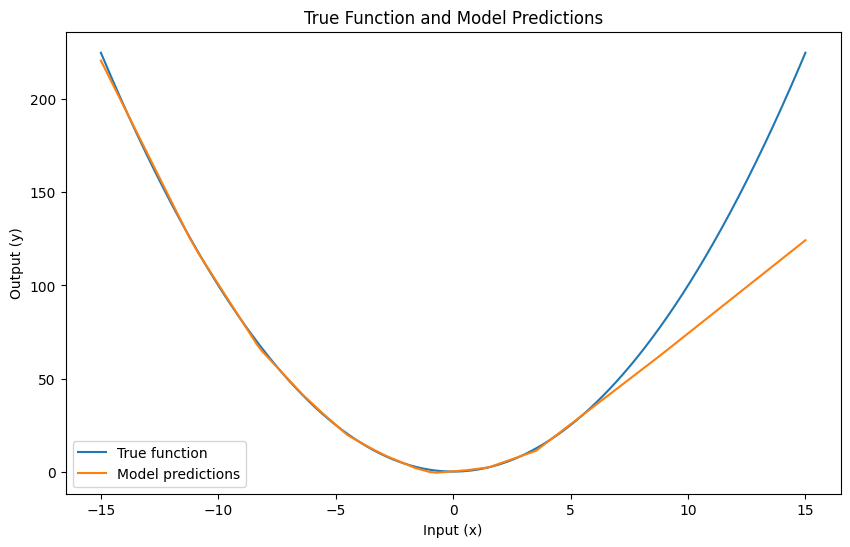

In [35]:
plot_predictions(model, x, y)